In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

In [3]:
import numpy as np

class Backpropagation:
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.output_size = output_size
        
        # Initialize weights and biases
        self.weights_input_hidden1 = np.random.randn(self.input_size, self.hidden_size1) * 0.01
        self.weights_hidden1_hidden2 = np.random.randn(self.hidden_size1, self.hidden_size2) * 0.01
        self.weights_hidden2_output = np.random.randn(self.hidden_size2, self.output_size) * 0.01
        
        self.bias_hidden1 = np.zeros((1, self.hidden_size1))
        self.bias_hidden2 = np.zeros((1, self.hidden_size2))
        self.bias_output = np.zeros((1, self.output_size))

    # Softmax Activation Function
    def softmax(self, x):
        exp_values = np.exp(x - np.max(x, axis=1, keepdims=True))  # For numerical stability
        return exp_values / np.sum(exp_values, axis=1, keepdims=True)

    # Feedforward
    def feedforward(self, X):
        # Hidden layer 1
        self.hidden1_activation = np.dot(X, self.weights_input_hidden1) + self.bias_hidden1
        self.hidden1_output = np.tanh(self.hidden1_activation)  # Example activation for hidden layers
        
        # Hidden layer 2
        self.hidden2_activation = np.dot(self.hidden1_output, self.weights_hidden1_hidden2) + self.bias_hidden2
        self.hidden2_output = np.tanh(self.hidden2_activation)
        
        # Output layer
        self.output_activation_layer = np.dot(self.hidden2_output, self.weights_hidden2_output) + self.bias_output
        self.predicted_output = self.softmax(self.output_activation_layer)

        return self.predicted_output

    # Backpropagation
    def backward(self, X, y, learning_rate):
        # Output layer error and delta
        output_error = self.predicted_output - y  # Cross-entropy loss simplifies gradient
        output_delta = output_error

        # Hidden layer 2 error and delta
        hidden2_error = np.dot(output_delta, self.weights_hidden2_output.T)
        hidden2_delta = hidden2_error * (1 - np.tanh(self.hidden2_output)**2)  # Derivative of tanh

        # Hidden layer 1 error and delta
        hidden1_error = np.dot(hidden2_delta, self.weights_hidden1_hidden2.T)
        hidden1_delta = hidden1_error * (1 - np.tanh(self.hidden1_output)**2)

        # Update weights and biases
        self.weights_hidden2_output -= np.dot(self.hidden2_output.T, output_delta) * learning_rate
        self.bias_output -= np.sum(output_delta, axis=0, keepdims=True) * learning_rate
        self.weights_hidden1_hidden2 -= np.dot(self.hidden1_output.T, hidden2_delta) * learning_rate
        self.bias_hidden2 -= np.sum(hidden2_delta, axis=0, keepdims=True) * learning_rate
        self.weights_input_hidden1 -= np.dot(X.T, hidden1_delta) * learning_rate
        self.bias_hidden1 -= np.sum(hidden1_delta, axis=0, keepdims=True) * learning_rate

    def train(self, X, y, epochs, learning_rate, track_loss=False):
        losses = []
        for epoch in range(epochs):
            output = self.feedforward(X)
            self.backward(X, y, learning_rate)
            
            # Compute Cross-Entropy Loss
            loss = -np.mean(np.sum(y * np.log(output + 1e-9), axis=1))  # Add small constant for numerical stability
            
            if track_loss:
                losses.append(loss)
            
            # Log loss
            if epoch % 1000 == 0 or epoch == epochs - 1:
                print(f"Epoch {epoch}, Loss: {loss}")
        
        return losses if track_loss else None


In [4]:
df = pd.read_csv('obesity-dataset-preprocessed.csv')
df.shape

(2063, 21)

Epoch 0, Loss: 1.9459157136271974
Epoch 1000, Loss: 0.5632786441600778
Epoch 2000, Loss: 0.5261949037824303
Epoch 3000, Loss: 0.6025163523293481
Epoch 4000, Loss: 0.7175269209969508
Epoch 5000, Loss: 0.687713240339349
Epoch 6000, Loss: 0.8145763569168715
Epoch 7000, Loss: 0.8373371766944872
Epoch 8000, Loss: 0.8618348465303777
Epoch 9000, Loss: 0.9233947513988889
Epoch 9999, Loss: 0.9647487079400316
Fold 1 Accuracy: 0.6464891041162227
              precision    recall  f1-score   support

           0       0.57      0.74      0.65        54
           1       0.54      0.33      0.41        57
           2       0.74      0.64      0.69        70
           3       0.66      0.86      0.75        59
           4       0.87      0.87      0.87        60
           5       0.52      0.51      0.51        55
           6       0.57      0.55      0.56        58

    accuracy                           0.65       413
   macro avg       0.64      0.64      0.63       413
weighted avg       

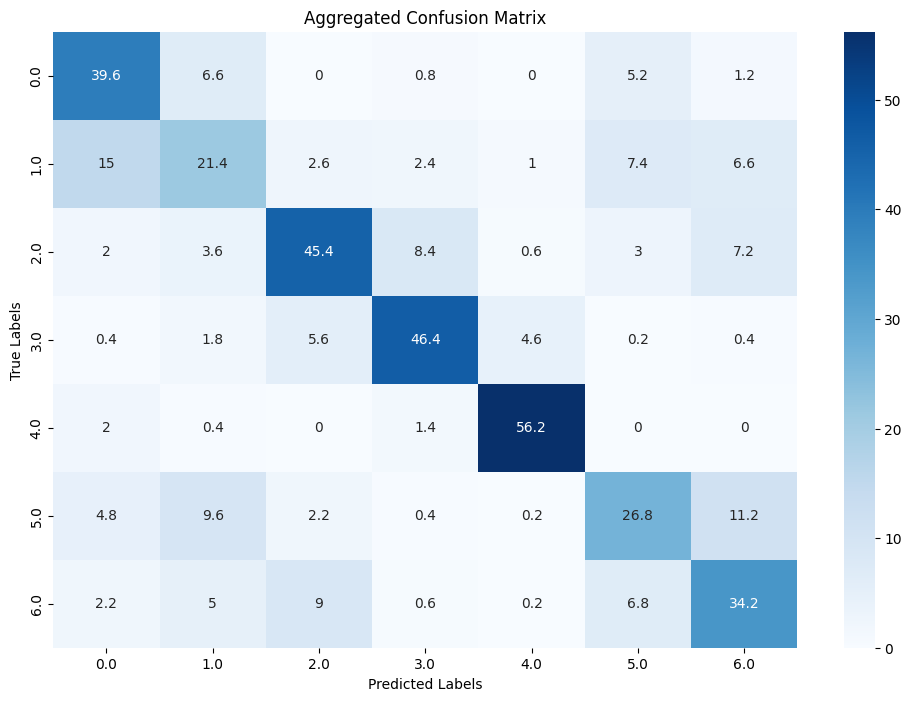

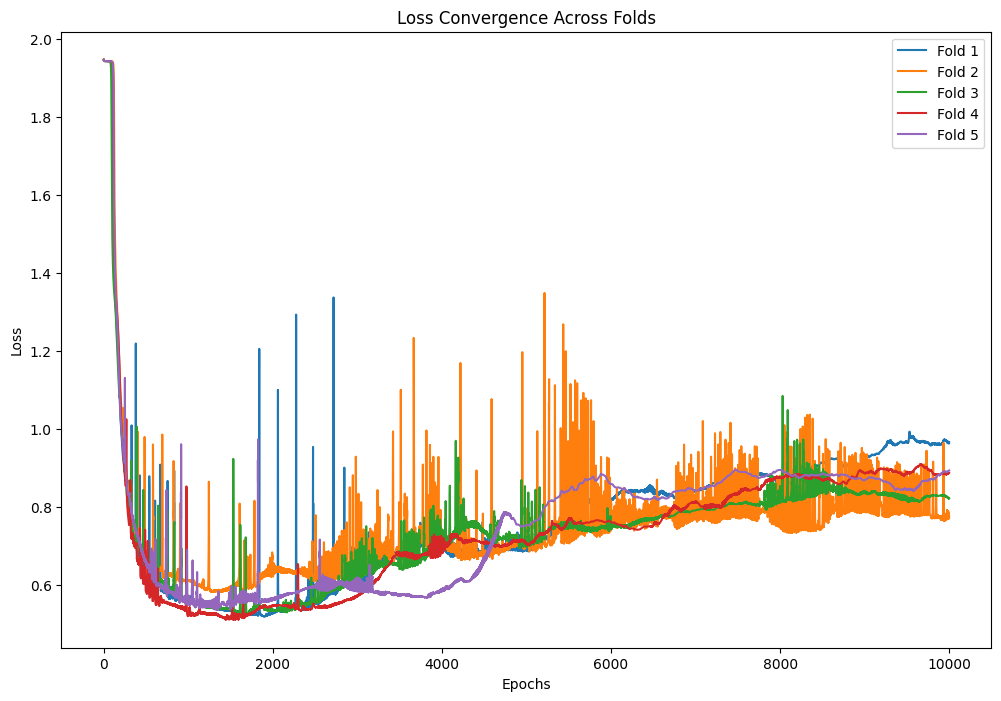

Average Convergence Speed: 0.0001078425


In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns

# Memisahkan fitur dan target
X = df.drop('NObeyesdad', axis=1)
y = df['NObeyesdad']

# Convert labels to one-hot encoding
y_one_hot = pd.get_dummies(y).to_numpy()

# Convert features to numpy
X = X.to_numpy()

# Scaling features (Hanya data pelatihan yang di-fit oleh scaler)
scaler = StandardScaler()

# Initialize cross-validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Model parameters
input_size = X.shape[1]
hidden_size1 = 10
hidden_size2 = 10
output_size = y_one_hot.shape[1]

# Placeholder for overall metrics
accuracies = []
classification_reports = []
confusion_matrices = []
convergence_speeds = []
losses_per_fold = []

# Cross-validation loop
for fold, (train_index, test_index) in enumerate(skf.split(X, y), start=1):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_one_hot[train_index], y_one_hot[test_index]

    # Scaling the features (fit scaler only on training data)
    X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform on train
    X_test_scaled = scaler.transform(X_test)        # Only transform on test

    # Initialize the neural network
    nn = Backpropagation(
        input_size=input_size,
        hidden_size1=hidden_size1,
        hidden_size2=hidden_size2,
        output_size=output_size,
    )

    # Train the model, track loss values for convergence speed
    losses = nn.train(X_train_scaled, y_train, epochs=10000, learning_rate=0.0005, track_loss=True)
    losses_per_fold.append(losses)

    # Calculate convergence speed (rate of loss reduction)
    if len(losses) > 1:
        convergence_speed = abs((losses[-1] - losses[0]) / len(losses))
        convergence_speeds.append(convergence_speed)

    # Generate predictions
    output = nn.feedforward(X_test_scaled)
    predictions = np.argmax(output, axis=1)  # Get class with highest probability
    true_labels = np.argmax(y_test, axis=1)  # Convert one-hot to class indices

    # Calculate accuracy
    accuracy = np.mean(predictions == true_labels)
    accuracies.append(accuracy)

    # Store classification report and confusion matrix
    classification_reports.append(classification_report(true_labels, predictions, output_dict=True))
    confusion_matrices.append(confusion_matrix(true_labels, predictions))

    print(f"Fold {fold} Accuracy: {accuracy}")
    print(classification_report(true_labels, predictions))

# Average accuracy across folds
print(f"Average Accuracy: {np.mean(accuracies)}")

# Aggregate confusion matrix
average_cm = np.mean(confusion_matrices, axis=0)

# Plot aggregated confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(average_cm, annot=True, fmt='g', cmap='Blues', xticklabels=pd.get_dummies(y).columns, yticklabels=pd.get_dummies(y).columns)
plt.title("Aggregated Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Plot loss convergence for each fold
plt.figure(figsize=(12, 8))
for fold, losses in enumerate(losses_per_fold, start=1):
    plt.plot(losses, label=f'Fold {fold}')
plt.title("Loss Convergence Across Folds")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Print convergence speed across folds
average_convergence_speed = np.mean(convergence_speeds)
print(f"Average Convergence Speed: {average_convergence_speed:.10f}")
